In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import utils
import eval
from train_utils import FallDataset, BalancedBatchSampler, Trainer, evaluate, KFoldCrossValidation

from model.stgcn import stgcn
from model.st_graph import get_distance_adjacency, get_uniform_adjacency, get_adjacency
from torch.utils.data import Dataset, DataLoader, Sampler
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

In [3]:
edges = [
    [0, 1],  # Nose - Left Eye
    [0, 2],  # Nose - Right Eye
    [1, 3],  # Left Eye - Left Ear
    [2, 4],  # Right Eye - Right Ear
    [1, 5],  # Left Eye - Left Shoulder
    [2, 6],  # Right Eye - Right Shoulder
    [5, 7],  # Left Shoulder - Left Elbow
    [6, 8],  # Right Shoulder - Right Elbow
    [7, 9],  # Left Elbow - Left Wrist
    [8, 10],  # Right Elbow - Right Wrist
    [5, 11],  # Left Shoulder - Left Hip
    [6, 12],  # Right Shoulder - Right Hip
    [11, 13],  # Left Hip - Left Knee
    [12, 14],  # Right Hip - Right Knee
    [13, 15],  # Left Knee - Left Ankle
    [14, 16]   # Right Knee - Right Ankle
]

# Load the Le2i Coffe Room and Home

In [4]:
# dict_keys(['filename', 'keypoints', 'scores', 'boxes', 'offset', 'fall_interval'])
coffee_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\falls.npy", allow_pickle=True)
coffee_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\non_falls.npy", allow_pickle=True)
home_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\falls.npy", allow_pickle=True)
home_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\non_falls.npy", allow_pickle=True)

In [5]:
coffee_falls = utils.clean(coffee_falls)
coffee_non_falls = utils.clean(coffee_non_falls)
home_falls = utils.clean(home_falls)
home_non_falls = utils.clean(home_non_falls)

In [6]:
c_fall_train, c_fall_test = train_test_split(coffee_falls, test_size=0.2)
c_nfall_train, c_nfall_test = train_test_split(coffee_non_falls, test_size=0.2)
h_fall_train, h_fall_test = train_test_split(home_falls, test_size=0.2)
h_nfall_train, h_nfall_test = train_test_split(home_non_falls, test_size=0.2)

c_test = [('coffee_room ' + data['filename'], data['keypoints'], data['frame_ids']) for data in c_fall_test.tolist()] + [('coffee_room ' + data['filename'], data['keypoints'], data['frame_ids']) for data in c_nfall_test.tolist()]
h_test = [('home ' + data['filename'], data['keypoints'], data['frame_ids']) for data in h_fall_test.tolist()] + [('home ' + data['filename'], data['keypoints'], data['frame_ids']) for data in h_nfall_test.tolist()]
test_data = c_test + h_test
test_labels = np.concatenate((np.ones(len(c_fall_test)), np.zeros(len(c_nfall_test)), np.ones(len(h_fall_test)), np.zeros(len(h_nfall_test))))

In [7]:
nframes = 45
shift_window = 0

falls = []
non_falls = []

train_falls, train_non_falls = utils.split_skeletons(c_fall_train, nframes=nframes, shift_window=shift_window)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(c_nfall_train, nframes=nframes, shift_window=shift_window)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(h_fall_train, nframes=nframes, shift_window=shift_window)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(h_nfall_train, nframes=nframes, shift_window=shift_window)
falls += train_falls
non_falls += train_non_falls

falls = np.array(falls)
non_falls = np.array(non_falls)

X_falls = falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates
X_non_falls = non_falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates

# X_falls = falls.astype(np.float32) # remove the scores only keep the coordinates
# X_non_falls = non_falls.astype(np.float32) # remove the scores only keep the coordinates

print(X_falls.shape, X_non_falls.shape)

(51, 45, 17, 2) (466, 45, 17, 2)


In [8]:
# normalize the data using the max values in the dataset
# the original coordinates is stored as (x, y)
# Le2i resolution is 320x240

max_x = 320
max_y = 240

X_falls[:, :, :, 0] /= max_x
X_falls[:, :, :, 1] /= max_y
X_non_falls[:, :, :, 0] /= max_x
X_non_falls[:, :, :, 1] /= max_y
X_falls = np.transpose(X_falls, (0, 3, 1, 2))
X_non_falls = np.transpose(X_non_falls, (0, 3, 1, 2))
print(X_falls.shape, X_non_falls.shape)

(51, 2, 45, 17) (466, 2, 45, 17)


# Initialize the model and dataset object

In [9]:
num_node = 17
A = get_uniform_adjacency(np.array(edges), num_node)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
falls_train, falls_valid = train_test_split(X_falls, test_size=0.2)
non_falls_train, non_falls_valid = train_test_split(X_non_falls, test_size=len(falls_valid))
training_set = FallDataset(falls=falls_train, non_falls=non_falls_train, window_size=45)
validation_set = FallDataset(falls=falls_valid, non_falls=non_falls_valid, window_size=45, valid=True)

In [12]:
layer_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]
default_layer_config = [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                        (128, 128, 1), (128, 256, 2), (256, 256, 1), (256, 256, 1)] # (in_channles, out_channels, temporal_stride)
my_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]

# Training loop

Training Loss: 0.3403: 100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Training loss: 0.34027776233652696
Validation loss: 0.404166579246521
Training accuracy: 0.9743315508021391
Validation accuracy: 0.9090909090909091


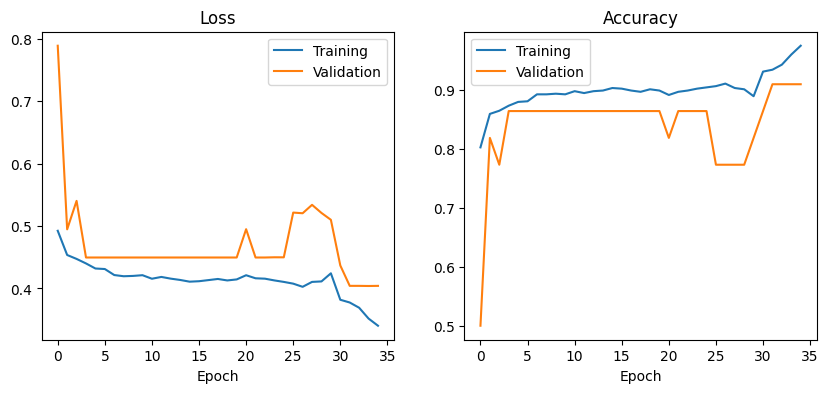

In [13]:
model = None
model = stgcn(num_class=2, window_size=45, num_point=17, graph=A, layer_config=default_layer_config, learnable_mask=True)
model.to(device)

# Set up TensorBoard
# writer = SummaryWriter()

epochs = 35
lr = 1e-3
weight_decay = 0
batch_size = 128
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

progress = tqdm(np.arange(epochs))
for n in progress:
    model.train()
    running_loss = 0
    running_acc = 0
    count = 0
    for X_batch, y_batch in training_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)

        y_pred = model(X_batch)
        batch_loss = loss_func(y_pred, y_batch)
        running_loss += batch_loss.item() * X_batch.size(0)
        running_acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        # for name, parameter in model.named_parameters():
        #     if parameter.grad is not None:
        #         writer.add_scalar(f'Gradient_norm/{name}', parameter.grad.norm(), n)
        
        count += X_batch.size(0)

    train_loss = running_loss / count
    train_acc = running_acc / count
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = evaluate(model, validation_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    progress.set_description(f'Training Loss: {train_loss:.4f}')

x_axis = np.arange(epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x_axis, train_loss_list, label="Training")
axes[0].plot(x_axis, val_loss_list, label="Validation")
axes[0].set_title("Loss")
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[1].plot(x_axis, train_acc_list, label='Training')
axes[1].plot(x_axis, val_acc_list, label='Validation')
axes[1].set_title("Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].legend()

print(f"Training loss: {train_loss_list[-1]}")
print(f"Validation loss: {val_loss_list[-1]}")
print(f"Training accuracy: {train_acc_list[-1]}")
print(f"Validation accuracy: {val_acc_list[-1]}")

# writer.flush()
# writer.close()

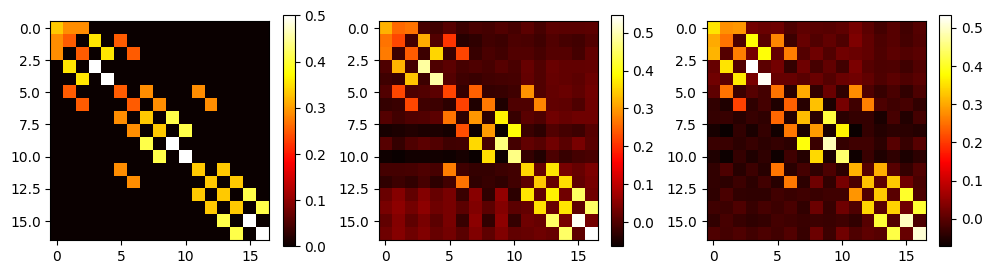

In [84]:
def undo_symnorm(A_symnorm, A):
    """Undo symmetric normalization on an adjacency matrix

    Args:
        A_symnorm: symnormed adjacency matrix

    Returns:
        A: original adjacency matrix
    """
    D = np.diag(np.sum(A, axis=0))
    D_sqrt = np.sqrt(D)
    return D_sqrt @ A_symnorm @ D_sqrt

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

im = ax[0].imshow(A[0], cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=ax[0])
im = ax[1].imshow((model.layers[0].sgcn.mask * model.layers[0].sgcn.A[0] + model.layers[0].sgcn.mask_bias)[0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=ax[1])
im = ax[2].imshow((model.layers[-2].sgcn.mask * model.layers[-2].sgcn.A[0] + model.layers[-2].sgcn.mask_bias)[0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=ax[2])

plt.show()

In [ ]:
torch.save(model.state_dict(), 'le2i_96acc_default.pth')

# Test on unseen data

In [17]:
LEC_ROOM_DIR = "D:\ASH\datasets\Le2i-skeleton\Lecture room\Skeletons_full_trim"
OFFICE_DIR = "D:\ASH\datasets\Le2i-skeleton\Office\Skeletons_full"

lec_room = eval.load_data(LEC_ROOM_DIR)
lec_room = [('lec_room ' + data[0], data[1], data[2]) for data in lec_room]
    
office = eval.load_data(OFFICE_DIR)
office = [('office ' + data[0], data[1], data[2]) for data in office]

In [18]:
unseen_test_data = lec_room + office
unseen_test_labels = eval.LEC_ROOM_LABELS + eval.OFFICE_LABELS

In [ ]:
KFoldCrossValidation(stgcn, 5, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr, batch_size, 50, weight_decay, False, shift_window_size=45, 
                     num_class=2, window_size=45, num_point=17, in_channels=2, graph=A, layer_config=default_layer_config, learnable_mask=True)

In [ ]:
KFoldCrossValidation(stgcn, 5, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr, batch_size, 50, weight_decay, False, shift_window_size=None, 
                     num_class=2, window_size=45, num_point=17, in_channels=2, graph=A, layer_config=default_layer_config, learnable_mask=True)

In [14]:
stride = 1
accuracy, specificity, sensitivity, results = eval.evaluate(model, device, testset=([data[:3] for data in test_data], test_labels), profile=True, stride=stride)
print(accuracy, specificity, sensitivity)

100%|██████████| 20/20 [00:05<00:00,  3.80it/s]

True positives: ['coffee_room video (16)', 'coffee_room video (35)', 'coffee_room video (29)', 'coffee_room video (50)', 'coffee_room video (33)', 'coffee_room video (39)', 'coffee_room video (30)', 'coffee_room video (36)', 'coffee_room video (18)', 'coffee_room video (34)', 'home video (25)']
True negatives: ['home video (51)', 'home video (42)', 'home video (48)', 'home video (55)']
False positives: ['coffee_room video (69)', 'coffee_room video (65)']
False negatives: ['coffee_room video (13)', 'coffee_room video (64)', 'home video (3)']
0.75 0.6666666666666666 0.7857142857142857


In [21]:
[data[0] for data in unseen_test_data]

['lec_room video (1)',
 'lec_room video (2)',
 'lec_room video (3)',
 'lec_room video (4)',
 'lec_room video (5)',
 'lec_room video (6)',
 'lec_room video (7)',
 'lec_room video (8)',
 'lec_room video (9)',
 'lec_room video (10)',
 'lec_room video (11)',
 'lec_room video (12)',
 'lec_room video (13)',
 'lec_room video (14)',
 'lec_room video (15)',
 'lec_room video (16) trim',
 'lec_room video (17)',
 'lec_room video (18)',
 'lec_room video (19)',
 'lec_room video (20)',
 'lec_room video (21) trim',
 'lec_room video (22) trim',
 'lec_room video (23)',
 'lec_room video (24)',
 'lec_room video (25) trim',
 'lec_room video (26)',
 'lec_room video (27) trim',
 'office video (1)',
 'office video (2)',
 'office video (3)',
 'office video (4)',
 'office video (5)',
 'office video (6)',
 'office video (7)',
 'office video (8)',
 'office video (9)',
 'office video (10)',
 'office video (11)',
 'office video (12)',
 'office video (13)',
 'office video (14)',
 'office video (15)',
 'office video 

In [123]:
sample = unseen_test_data[21]

batch = eval.create_batch(sample[1])

In [ ]:
start_frame = 140
joints = np.transpose(batch[start_frame], (1, 2, 0))

# Create a figure and axis
fig, ax = plt.subplots()
scatter = ax.scatter([], [])
lines = LineCollection([], color='red')
ax.add_collection(lines)
ax.set_title('{} frames'.format(len(joints)))

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.invert_yaxis()  # Invert y-axis

# Update function for animation
def update(frame):
    scatter.set_offsets(joints[frame])
    segments = []
    for joint1, joint2 in edges:
        x_values = [joints[frame][joint1][0], joints[frame][joint2][0]]
        y_values = [joints[frame][joint1][1], joints[frame][joint2][1]]
        segments.append([(x_values[0], y_values[0]), (x_values[1], y_values[1])])
    lines.set_segments(segments)
    return scatter, lines

# Create animation
ani = FuncAnimation(fig, update, frames=len(joints), blit=True)

# Save animation as GIF
ani.save(f'fall_frame_{start_frame}.gif', fps=25)


# Visualization

In [23]:
import time

In [31]:
filename, skeletons, frame_ids = unseen_test_data[-2]
print(filename)
start_time = time.time()
batch = eval.create_batch(skeletons)
model.eval()
with torch.no_grad():
    batch_tensor = torch.tensor(batch).to(device)
    pred = model(batch_tensor).cpu()
results = torch.argmax(pred, axis=-1).numpy()
runtime = time.time() - start_time
print(f"Inference time on {len(batch)} sub-sequences: {runtime}. The average time: {runtime / len(results)}")

office video (32)
Inference time on 401 sub-sequences: 0.40932440757751465. The average time: 0.0010207591211409343


In [32]:
# This is an example, replace it with your video path
video_path = "D:\ASH\datasets\Le2i\Office\Videos\\video (32).avi"
cap = cv2.VideoCapture(video_path)

output_video_path = 'output_video.avi'  # Path to save the output video
frame_width = 320  # Width of the frames in the video
frame_height = 240  # Height of the frames in the video
fps = 25  # Frames per second
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Specify the codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_ptr = 0
curr_frame = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    position = (10, 10)  # Coordinates of the upper left corner
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)
    text = "N/A"
    
    if frame_ptr < len(frame_ids) and frame_ids[frame_ptr] == curr_frame:
        pred_idx = frame_ptr - 45 + 1
        if pred_idx >= 0 and pred_idx < len(results):
            pred = results[pred_idx]
            if pred == 1:
                text = "Fall"
                font_color = (0, 0, 255)
            else:
                text = "No fall"
                font_color = (0, 255, 0)
            
        # Example joint coordinates for one person in the frame
        # Replace this with your actual detection data
        # Format: [x, y, confidence]
        joints = skeletons[frame_ptr]
        
        # Draw joints
        for joint in joints:
            # Convert coordinates to integers
            x, y = int(joint[0]), int(joint[1])
            cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)
        
        # Draw skeleton
        for bone in edges:
            # Convert coordinates to integers
            start_point, end_point = joints[bone[0]], joints[bone[1]]
            start_point = (int(start_point[0]), int(start_point[1]))
            end_point = (int(end_point[0]), int(end_point[1]))
            cv2.line(frame, start_point, end_point, (255, 0, 0), 2)
        
        frame_ptr += 1
    
    cv2.putText(frame, text, position, font, font_scale, font_color, thickness=2)

    # Display the frame with drawn joints and connections
    cv2.imshow('Frame', frame)
    out.write(frame)
    
    # if frame_ptr >= len(results): break 
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    
    curr_frame += 1

# Release everything if job is finished
out.release()
cap.release()
cv2.destroyAllWindows()